In [55]:
import pandas as pd
import numpy as np
import torch
import transformers
import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### Load data

In [60]:
df = pd.read_csv("./drive/MyDrive/ko-cover-letter-ai/jobkorea_preprocessed_answer_title.csv")

In [31]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained("gogamza/kobart-base-v2")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


### Preprocessing & Tokenizeing data

#### Load Tokenizer

In [61]:
df['title_length'] = 0
df['answer_length'] = 0
for idx in tqdm(range(df.shape[0])):
    df.loc[idx, "answer_length"] = len(tokenizer.encode(df.loc[idx, "답변"]))
    df.loc[idx, "title_length"] = len(tokenizer.encode(df.loc[idx, "제목"]))

100%|██████████| 13599/13599 [00:21<00:00, 624.74it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


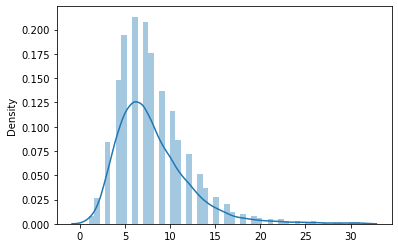

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


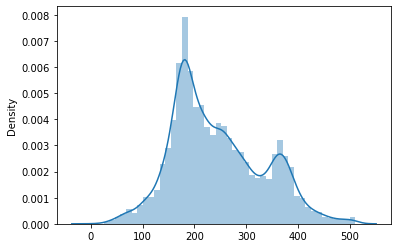

In [62]:
df = df[(df['title_length'] < 32) & (df['answer_length'] < 512)].reset_index(drop=True)

# Visualize input data
sns.distplot(df["title_length"].to_list())
plt.show()
sns.distplot(df["answer_length"].to_list())
plt.show()

df = df[["답변", "제목"]]

In [63]:
train_df, test_df = train_test_split(df, test_size=0.1)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Convert DataFrame to transformers DatasetDict
train_dataset = datasets.Dataset.from_pandas(train_df)
test_dataset = datasets.Dataset.from_pandas(test_df)
dataset = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})

#### Tokenize answer

In [64]:
def tokenize_answer(data):
    data = tokenizer(data["답변"], padding="max_length", max_length=512, truncation=False)
    return data

In [65]:
tokenized_dataset = dataset.map(tokenize_answer, num_proc=5, remove_columns=["답변"])

#0:   0%|          | 0/2258 [00:00<?, ?ex/s]

#1:   0%|          | 0/2258 [00:00<?, ?ex/s]

#2:   0%|          | 0/2257 [00:00<?, ?ex/s]

#3:   0%|          | 0/2257 [00:00<?, ?ex/s]

#4:   0%|          | 0/2257 [00:00<?, ?ex/s]

#0:   0%|          | 0/251 [00:00<?, ?ex/s]

#1:   0%|          | 0/251 [00:00<?, ?ex/s]

#2:   0%|          | 0/251 [00:00<?, ?ex/s]

#3:   0%|          | 0/251 [00:00<?, ?ex/s]

#4:   0%|          | 0/251 [00:00<?, ?ex/s]

#### Tokenize title

In [66]:
def tokenize_title(data):
    data['labels'] = tokenizer.encode(data["제목"], padding="max_length", max_length=32, truncation=False)
    return data

In [67]:
tokenized_dataset = tokenized_dataset.map(tokenize_title, num_proc=5, remove_columns=["제목"])

#0:   0%|          | 0/2258 [00:00<?, ?ex/s]

#1:   0%|          | 0/2258 [00:00<?, ?ex/s]

#2:   0%|          | 0/2257 [00:00<?, ?ex/s]

#3:   0%|          | 0/2257 [00:00<?, ?ex/s]

#4:   0%|          | 0/2257 [00:00<?, ?ex/s]

#0:   0%|          | 0/251 [00:00<?, ?ex/s]

#1:   0%|          | 0/251 [00:00<?, ?ex/s]

#2:   0%|          | 0/251 [00:00<?, ?ex/s]

#3:   0%|          | 0/251 [00:00<?, ?ex/s]

#4:   0%|          | 0/251 [00:00<?, ?ex/s]

In [68]:
tokenized_dataset = tokenized_dataset.remove_columns("token_type_ids")

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 11287
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1255
    })
})

### Fine tuning - BART

#### Load koBART

In [69]:
from transformers import BartForConditionalGeneration
model = BartForConditionalGeneration.from_pretrained("gogamza/kobart-base-v2")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


Downloading:   0%|          | 0.00/496M [00:00<?, ?B/s]

#### Set Arguments

In [71]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="test_trainer",
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=10, # number of training epochs
    per_device_train_batch_size=8, # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    save_strategy="epoch",
    evaluation_strategy = "epoch",
    learning_rate=5e-5,
    warmup_steps=500, # number of warmup steps for learning rate scheduler
    weight_decay=0.01, # Weight Regularization
    save_steps=1000, # steps model is saved 
    load_best_model_at_end=True,
)

In [72]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"]
)

#### Training

In [73]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 11287
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14110


Epoch,Training Loss,Validation Loss
1,0.643400,0.554637
2,0.411400,0.516374
3,0.247900,0.518325
4,0.140100,0.540812
5,0.073900,0.567873
6,0.036200,0.587955
7,0.019000,0.602879
8,0.010700,0.605734
9,0.006300,0.615838
10,0.003900,0.617687


The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1255
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-1411
Configuration saved in test_trainer/checkpoint-1411/config.json
Model weights saved in test_trainer/checkpoint-1411/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1255
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-2822
Configuration saved in test_trainer/checkpoint-2822/config.jso

TrainOutput(global_step=14110, training_loss=0.2281062202809298, metrics={'train_runtime': 7474.7225, 'train_samples_per_second': 15.1, 'train_steps_per_second': 1.888, 'total_flos': 3.44104770207744e+16, 'train_loss': 0.2281062202809298, 'epoch': 10.0})